In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from data_preprocessing import preprocess_data
from data_loading import load_data
from models import cross_val_pr_curve,tune_hyperparameters

In [2]:
train_data_path="D:/Pycharm/AutoLoanModel/Training Dataset.csv"
test_data_path="D:/Pycharm/AutoLoanModel/Testing Dataset.csv"
df_train, df_test = load_data(train_data_path,test_data_path)
X_train_processed, y_train, X_test_processed, y_test=preprocess_data(df_train, df_test)

In [3]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight':['balanced']
}

best_params=tune_hyperparameters(X_train_processed,y_train,param_grid,RandomForestClassifier(),'average_precision')

print("Best Hyperparameters for RnadomForest Regression:", best_params)


Best Hyperparameters for Logistic Regression: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [4]:
# Train RandomForest Regression model with best hyperparameters
rf_model = RandomForestClassifier(**best_params)
rf_model.fit(X_train_processed, y_train);

Cross-Validation Precision Scores: [0.93874783 0.93859146 0.94074529]
Mean Precision Score: 0.9393615262483541
Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.55      0.65      5654
           1       0.86      0.96      0.90     15952

    accuracy                           0.85     21606
   macro avg       0.83      0.75      0.78     21606
weighted avg       0.84      0.85      0.84     21606



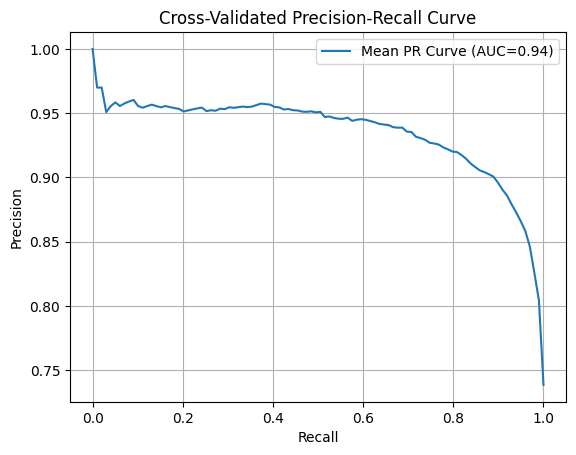

Mean Precision-Recall AUC: 0.9390


In [5]:
from models import evaluate_models
evaluate_models(rf_model, X_train_processed, y_train,'average_precision')

**Feature Importance Using Permuatiuon**


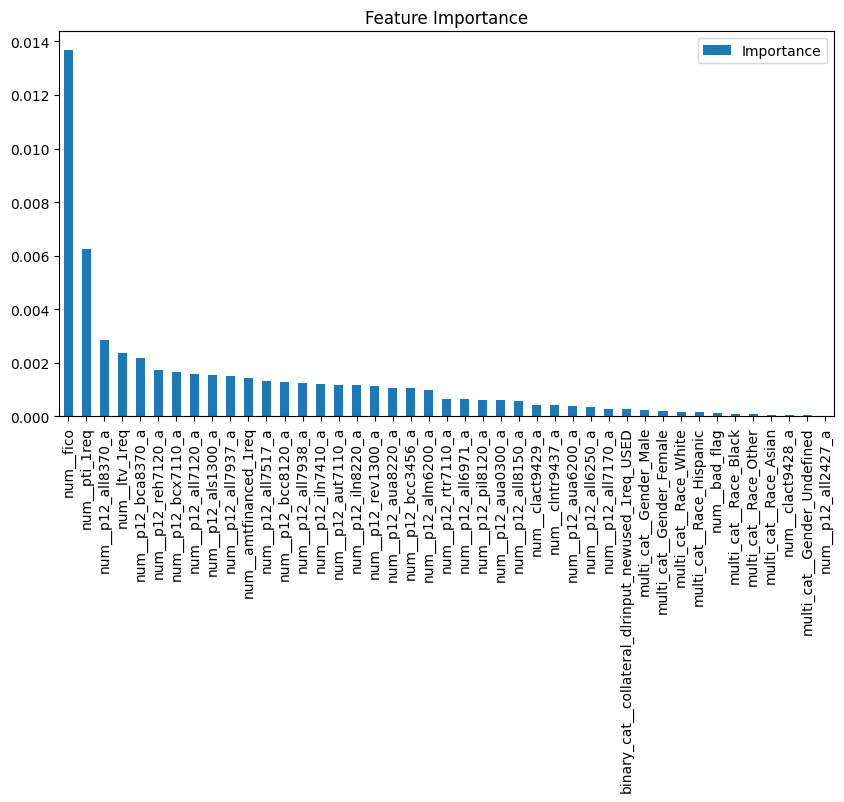

In [7]:
from models import feature_importance
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
feature_importance(rf_model, X_train_processed, y_train,'average_precision')